# MultiCPD NYC TLC 2020 Notebook

### Import block

In [1]:
# standard library dependencies
import warnings
import datetime
from pprint import pprint
from typing import List, Callable, Tuple

# external dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

# local dependencies
from datasets.TLC_loader import load_TLC
from sc_multiCPD import multiCPD, plot_scores_and_spectra, PCA_context_matrix
from multiCPD_multiview_aggregators import (
    sum_,
    mean_,
    max_,
    min_,
    median_,
    scalar_power_mean
)

%load_ext autoreload
%autoreload 2

### Convenience function definition

In [2]:
def visualize(context_matrix: np.ndarray, 
              z_scores: np.ndarray, 
              z_overall: np.ndarray, 
              line_labels: List[str],
              x_axis_labels: List[str],
              anomalous_timepoints: List[int],
              suptitle: str = None,
              line_colours: List[str] = None,
              pca_analysis: bool = False,
              plot_maxline: bool = False,
              figsize: Tuple[int,int] = None,
              show: bool = False):
    
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['axes.xmargin'] = 0
    plt.rcParams.update({'figure.autolayout': True})
    plt.rc('xtick')
    plt.rc('ytick')
    
    if line_colours is None:
        line_colours = ['red', 'blue', 'green', 'yellow', 'purple', 'black']
    
    if plot_maxline:
        lines_array = np.clip(
            np.vstack((z_scores, z_overall)),
            a_min=0.0, 
            a_max=None
        )
    else:
        lines_array = np.clip(
            z_scores,
            a_min=0.0, 
            a_max=None
        )
    
    LAD_fig, no_spectra_LAD_fig = plot_scores_and_spectra(
        context_matrix, 
        lines_array,
        labels = line_labels,
        x_axis_labels = x_axis_labels,
        colors = line_colours,
        anomalous_timepoints = anomalous_timepoints,
        title = suptitle,
        figsize=figsize
    )
    
    if pca_analysis:
        transformed_context_matrix, PCA_fig = PCA_context_matrix(
            context_matrix, 
            verbose=True, 
            plot=True, 
            point_labels=x_axis_labels
        )
        return LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig
    return LAD_fig, no_spectra_LAD_fig, None, None

def visualize_max(zs: List[np.ndarray],
                  dates:List,
                  num_timepoints:int=121):
    
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['axes.xmargin'] = 0
    plt.rcParams.update({'figure.autolayout': True})
    plt.rc('xtick')
    plt.rc('ytick')
    
    fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10,4), sharex=True, sharey=True)
    xs = np.arange(num_timepoints)
    x_ticks = [ x for x in xs if x%7 == 0 ]
    x_labels = [ d.strftime("%m-%d") for d, t in zip(dates, xs) if t % 7 == 0 ]
    for i in range(len(zs)):
        ax[i].plot(
            xs,
            np.clip(zs[i], a_min=0.0, a_max=None),
            'k-'
        )
    plt.xticks(x_ticks, x_labels)
    fig.autofmt_xdate()
    plt.xlabel("date")
    fig.text(0.0, 0.5, 'anomaly score', va='center', rotation='vertical')
    return fig

### Parameter block

In [3]:
window_sizes = [3,7]
windows_suffix = ",".join(list(map(str, window_sizes)))
percent_ranked = 0.06
normalized_laplacian = True
# add the path to the directory containing 
# green_tripdata_2020.edgelist.txt,
# yellow_tripdata_2020.edgelist.txt,
# fhv_tripdata_2020.edgelist.txt, and
# fhvhv_tripdata_2020.edgelist.txt
# here
TLC_data_dir_path = ""

### Load the NYC TLC 2020 dataset
The data in `viewwise_G_times` is a list of list of networkx.Graph objects.
Each sublist corresponds to a view (e.g. the green taxi view, or the yellow taxi view), and each graph in the sublist represents a day in the timecourse.

In [5]:
num_timepoints = 121
viewwise_G_times = load_TLC(
    4, 
    day_range=list(range(num_timepoints)),
    TLC_data_dir_path=TLC_data_dir_path
)
dates = [datetime.date(month=1, year=2020, day=1) + datetime.timedelta(days=x) for x in range(121)]

ordering of returned timecourse datasets:  ['green_tripdata_2020.edgelist.txt', 'yellow_tripdata_2020.edgelist.txt', 'fhv_tripdata_2020.edgelist.txt', 'fhvhv_tripdata_2020.edgelist.txt']
# days: 121  ranging from  0  to  120
# days: 121  ranging from  0  to  120
# days: 121  ranging from  0  to  120
# days: 121  ranging from  0  to  120


## MultiCPD Experiments

### Running MultiCPD on all 4 views using the scalar power mean

In [6]:
context_matrix, z_overall, z_scores, anomalies = multiCPD(
    viewwise_G_times, 
    window_sizes,
    num_eigen = 499,
    p = -10,
    max_size = None,
    add_diagonal_shift = True,
    top = True,
    principal = True,
    difference = True,
    percent_ranked = percent_ranked,
    normalized_laplacian = True,
    weight = 'weight',
    multiview_agg_fn = scalar_power_mean,
    context_matrix_norm = 'l2'
)
scalar_power_mean_z_overall = z_overall[:]
print([dates[i].strftime("%m-%d") for i in anomalies])

Processing timepoints:   1%|          | 1/121 [00:00<00:16,  7.21it/s]

Setting max_size and num_eigen to min(266 - 1, 499)


Processing timepoints:   1%|          | 1/121 [00:00<00:16,  7.30it/s]

Setting max_size and num_eigen to min(266 - 1, 499)


Processing timepoints:   1%|          | 1/121 [00:00<00:15,  7.87it/s]

Setting max_size and num_eigen to min(266 - 1, 499)


Processing timepoints:   1%|          | 1/121 [00:00<00:20,  5.86it/s]

Setting max_size and num_eigen to min(266 - 1, 499)


Processing timepoints: 100%|██████████| 121/121 [00:30<00:00,  3.96it/s]

['03-14', '03-21', '03-22', '03-29', '04-05', '04-18', '04-22']


explained variance ratio:  [0.9249801  0.03024286]
singular values:  [0.09785774 0.01769459]
[ 73  80  81  88  95 108 112]
explained variance ratio:  [0.9249801  0.03024286]
singular values:  [0.09785774 0.01769459]


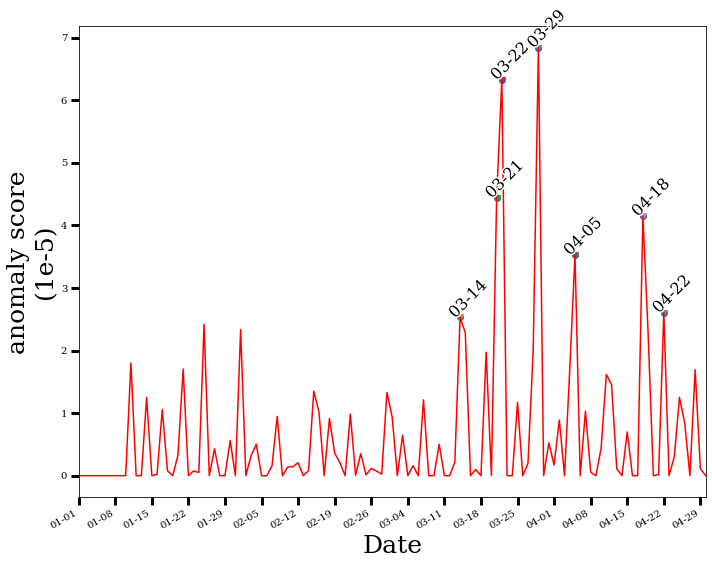

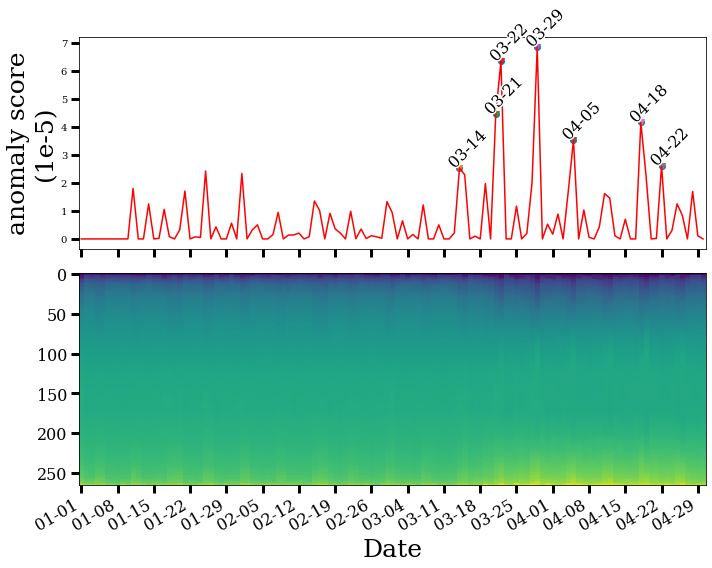

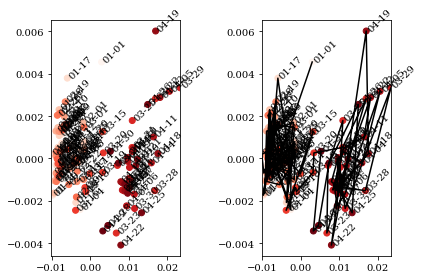

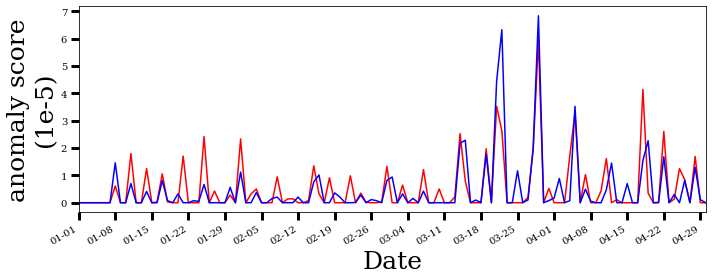

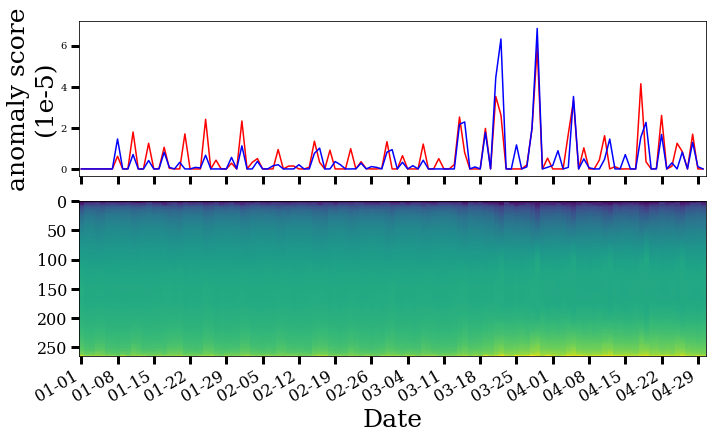

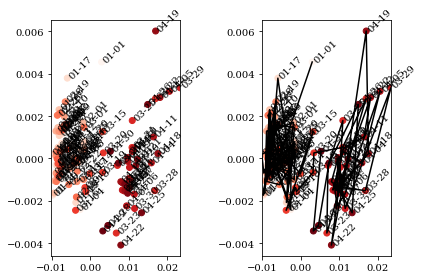

In [7]:
LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, 
    z_overall.reshape((1,-1)), 
    z_overall.reshape((1,-1)), 
    [''],#list(map(str, window_sizes)),
    [d.strftime("%m-%d") for d in dates],
    anomalies,
    suptitle = "",
    line_colours = None, 
    pca_analysis = True,
    figsize = (10,8)
)
topn = len(anomalies)
print(anomalies)
LAD_fig.savefig(f"Scalar Power Mean MultiCPD (NYC TLC 2020, top {topn}, spectra, windows={windows_suffix}).pdf", bbox_inches='tight')

# re-plot w/o anomalies labels
LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, 
    z_scores, 
    z_overall, 
    list(map(str, window_sizes)),
    [d.strftime("%m-%d") for d in dates],
    [],
    suptitle = "",
    line_colours = None, 
    pca_analysis = True
)


%matplotlib inline
weekday_overall_z_scores_distribution = []
for offset in range(7):
    weekday_overall_z_scores_distribution.append(
        np.clip(
            z_overall[offset::7],
            a_min=0.0,
            a_max=None
        ).tolist()
    )


#df.columns = ["Wed.", "Thu.", "Fri.", "Sat.", "Sun.", "Mon.", "Tue."]
fig, ax = plt.subplots(figsize=(9,5))
sns.set(font_scale = 2)
sns.boxplot(ax=ax, data=weekday_overall_z_scores_distribution)
sns.swarmplot(ax=ax, data=weekday_overall_z_scores_distribution, color=".25")
plt.xticks(list(range(0,7)), ["Wed.", "Thu.", "Fri.", "Sat.", "Sun.", "Mon.", "Tue."])
plt.ylabel("anomaly score")
plt.suptitle("Scalar Power Mean MultiCPD (NYC TLC 2020)\nDaily Max. Score Distributions")
plt.show()
plt.savefig("Scalar Power Mean MultiCPD (NYC TLC 2020) Daily Max. Score Distributions (windows={windows_suffix}).pdf")

### Running MultiCPD on all 4 views using the mean and max aggregation baselines

In [ ]:
viewwise_z_overall = []
for i in range(4):
    context_matrix, z_overall, z_scores, anomalies = multiCPD(
        [viewwise_G_times[i]], 
        window_sizes,
        num_eigen = 499,
        p = -10,
        max_size = None,
        add_diagonal_shift = True,
        top = True,
        principal = True,
        difference = True,
        percent_ranked = percent_ranked,
        normalized_laplacian = normalized_laplacian,
        weight = 'weight',
        context_matrix_norm = 'l2'
    )
    viewwise_z_overall.append(z_overall)

viewwise_z_overall = np.array(viewwise_z_overall)
assert viewwise_z_overall.ndim == 2
print(viewwise_z_overall.shape)

mean_z_overall = viewwise_z_overall.mean(axis=0)
mean_anomalies = mean_z_overall.argsort()[-round(num_timepoints * percent_ranked):][::-1]
mean_anomalies.sort()

max_z_overall = viewwise_z_overall.max(axis=0)
max_anomalies = max_z_overall.argsort()[-round(num_timepoints * percent_ranked):][::-1]
max_anomalies.sort()

print([dates[i].strftime("%m-%d") for i in mean_anomalies])
print([dates[i].strftime("%m-%d") for i in max_anomalies])

In [ ]:
scalar_power_mean_z_overall.max(), mean_z_overall.max(), max_z_overall.max()
max_norm_scalar_power_mean_z_overall = scalar_power_mean_z_overall / scalar_power_mean_z_overall.max()
max_norm_mean_z_overall = mean_z_overall / mean_z_overall.max()
max_norm_max_z_overall = max_z_overall / max_z_overall.max()

LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, # dummy
    np.vstack((
        max_norm_mean_z_overall,
        max_norm_max_z_overall,
        max_norm_scalar_power_mean_z_overall
    )),
    max_norm_scalar_power_mean_z_overall,
    ["NL meanLAD Baseline", "NL maxLAD Baseline", "Scalar Power Mean"],
    [d.strftime("%m-%d") for d in dates],
    np.zeros((0,0)),
    #suptitle = "Scalar Power Mean multiCPD versus NL mean/maxLAD Baselines (NYC TLC 2020)",
    line_colours = None, 
    pca_analysis = False
)
LAD_fig.axes[0].set_yticklabels(np.round(np.arange(-0.2, 1.2, 0.2), 2))
LAD_fig.axes[0].set(ylabel = "normalized anomaly score")
LAD_fig.savefig(f"Scalar Power Mean multiCPD versus NL meanLAD and maxLAD Baselines (NYC TLC 2020, w={windows_suffix}).pdf", bbox_inches='tight')


no_spectra_LAD_fig.axes[0].set_yticklabels(np.round(np.arange(-0.2, 1.2, 0.2), 2))
no_spectra_LAD_fig.axes[0].set(ylabel = "normalized anomaly score")
no_spectra_LAD_fig.savefig(f"Scalar Power Mean multiCPD versus NL meanLAD and maxLAD Baselines (NYC TLC 2020, no spectra, w={windows_suffix}).pdf", bbox_inches='tight')

In [ ]:
LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, # dummy
    max_z_overall.reshape((1,-1)), 
    max_z_overall.reshape((1,-1)), 
    ["NL maxLAD Baseline"],
    [d.strftime("%m-%d") for d in dates],
    max_anomalies,
    #suptitle = "NL maxLAD (NYC TLC 2016) Baseline, top 7\n",
    line_colours = None, 
    pca_analysis = True
)
no_spectra_LAD_fig.savefig("NL maxLAD (NYC TLC 2020, top 7, windows=(3,17), no spectra) Baseline.pdf", bbox_inches='tight')

In [ ]:
LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, # dummy
    mean_z_overall.reshape((1,-1)), 
    mean_z_overall.reshape((1,-1)), 
    ["NL meanLAD Baseline"],
    [d.strftime("%m-%d") for d in dates],
    max_anomalies,
    line_colours = None, 
    pca_analysis = True
)
no_spectra_LAD_fig.savefig("NL meanLAD (NYC TLC 2020, top 7, windows=(3,17), no spectra) Baseline.pdf", bbox_inches='tight')

## Single-view Experiments

In [ ]:
normalized_laplacian = True

### View 1

In [ ]:
context_matrix, z_overall, z_scores, anomalies = multiCPD(
    [viewwise_G_times[0]], 
    window_sizes,
    num_eigen = 499,
    p = -10,
    max_size = None,
    add_diagonal_shift = True,
    top = True,
    principal = True,
    difference = True,
    percent_ranked = percent_ranked,
    normalized_laplacian = normalized_laplacian,
    weight = 'weight',
    context_matrix_norm = 'l2'
)
view_1_z_overall = z_overall

In [ ]:
LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, 
    z_scores, 
    z_overall, 
    list(map(str, window_sizes)),
    [d.strftime("%m-%d") for d in dates],
    anomalies,
    #suptitle = "LAD on View #1 (NYC TLC 2020), top 10%\n",
    line_colours = None, 
    pca_analysis = True,
    figsize = (10,2)
)
topn = len(anomalies)
no_spectra_LAD_fig.savefig(f"Resized {'NL ' if normalized_laplacian else ''}LAD on View #1 (NYC TLC 2020, top {topn}, no spectra, windows={windows_suffix}).pdf", bbox_inches='tight')

LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, 
    z_scores, 
    z_overall, 
    list(map(str, window_sizes)),
    [d.strftime("%m-%d") for d in dates],
    [],
    suptitle = "",
    line_colours = None, 
    pca_analysis = True
)


### View 2

In [ ]:
context_matrix, z_overall, z_scores, anomalies = multiCPD(
    [viewwise_G_times[1]], 
    window_sizes,
    num_eigen = 499,
    p = -10,
    max_size = None,
    add_diagonal_shift = True,
    top = True,
    principal = True,
    difference = True,
    percent_ranked = percent_ranked,
    normalized_laplacian = normalized_laplacian,
    weight = 'weight',
    context_matrix_norm = 'l2'
)
view_2_z_overall = z_overall

In [ ]:
LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, 
    z_scores, 
    z_overall, 
    list(map(str, window_sizes)),
    [d.strftime("%m-%d") for d in dates],
    anomalies,
    #suptitle = "LAD on View #2 (NYC TLC 2020), top 10%\n",
    line_colours = None, 
    pca_analysis = True,
    figsize = (10,2)
)
topn = len(anomalies)
no_spectra_LAD_fig.savefig(f"Resized {'NL ' if normalized_laplacian else ''}LAD on View #2 (NYC TLC 2020, top {topn}, no spectra, windows={windows_suffix}).pdf", bbox_inches='tight')

LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, 
    z_scores, 
    z_overall, 
    list(map(str, window_sizes)),
    [d.strftime("%m-%d") for d in dates],
    [],
    suptitle = "",
    line_colours = None, 
    pca_analysis = True
)


### View 3

In [ ]:
context_matrix, z_overall, z_scores, anomalies = multiCPD(
    [viewwise_G_times[2]], 
    window_sizes,
    num_eigen = 499,
    p = -10,
    max_size = None,
    add_diagonal_shift = True,
    top = True,
    principal = True,
    difference = True,
    percent_ranked = percent_ranked,
    normalized_laplacian = normalized_laplacian,
    weight = 'weight',
    context_matrix_norm = 'l2'
)
view_3_z_overall = z_overall

In [ ]:
LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, 
    z_scores, 
    z_overall, 
    list(map(str, window_sizes)),
    [d.strftime("%m-%d") for d in dates],
    anomalies,
    #suptitle = "LAD on View #3 (NYC TLC 2020), top 10%\n",
    line_colours = None, 
    pca_analysis = True,
    figsize = (10,2)
)
topn = len(anomalies)
no_spectra_LAD_fig.savefig(f"Resized {'NL ' if normalized_laplacian else ''}LAD on View #3 (NYC TLC 2020, top {topn}, no spectra, windows={windows_suffix}).pdf", bbox_inches='tight')

# re-plot w/o anomalies labels
LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, 
    z_scores, 
    z_overall, 
    list(map(str, window_sizes)),
    [d.strftime("%m-%d") for d in dates],
    [],
    suptitle = "",
    line_colours = None, 
    pca_analysis = True
)


### View 4

In [ ]:
context_matrix, z_overall, z_scores, anomalies = multiCPD(
    [viewwise_G_times[3]], 
    window_sizes,
    num_eigen = 499,
    p = -10,
    max_size = None,
    add_diagonal_shift = True,
    top = True,
    principal = True,
    difference = True,
    percent_ranked = percent_ranked,
    normalized_laplacian = normalized_laplacian,
    weight = 'weight',
    context_matrix_norm = 'l2'
)
view_4_z_overall = z_overall

In [ ]:
LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, 
    z_scores, 
    z_overall, 
    list(map(str, window_sizes)),
    [d.strftime("%m-%d") for d in dates],
    anomalies,
    #suptitle = "LAD on View #4 (NYC TLC 2020), top 10%\n",
    line_colours = None, 
    pca_analysis = True,
    figsize = (10,2)
)
topn = len(anomalies)
no_spectra_LAD_fig.savefig(f"Resized {'NL ' if normalized_laplacian else ''}LAD on View #4 (NYC TLC 2020, top {topn}, no spectra, windows={windows_suffix}).pdf", bbox_inches='tight')

# re-plot w/o anomalies labels
LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, 
    z_scores, 
    z_overall, 
    list(map(str, window_sizes)),
    [d.strftime("%m-%d") for d in dates],
    [],
    suptitle = "",
    line_colours = None, 
    pca_analysis = True
)


In [ ]:
f = visualize_max(
    [
        scalar_power_mean_z_overall,
        view_1_z_overall,
        view_2_z_overall,
        view_3_z_overall,
        view_4_z_overall
    ], 
    dates
)
f.savefig("NYC TLC 2020 SPM, v1, v2, v3, v4 (windows=3,7).pdf")

In [ ]:
f = visualize_max(
    [
        scalar_power_mean_z_overall/(scalar_power_mean_z_overall.max()),
        view_1_z_overall/(view_1_z_overall.max()),
        view_2_z_overall/(view_2_z_overall.max()),
        view_3_z_overall/(view_3_z_overall.max()),
        view_4_z_overall/(view_4_z_overall.max())
    ], 
    dates
)
f.savefig("NYC TLC 2020 SPM, v1, v2, v3, v4 (windows=3,7, normalized).pdf")

## Complementary Views Experiments

In [ ]:
normalized_laplacian = True

### Taxi MultiCPD

In [ ]:
context_matrix, z_overall, z_scores, anomalies = multiCPD(
    viewwise_G_times[0:2], 
    window_sizes,
    num_eigen = 499,
    p = -10,
    max_size = None,
    add_diagonal_shift = True,
    top = True,
    principal = True,
    difference = True,
    percent_ranked = percent_ranked,
    normalized_laplacian = normalized_laplacian,
    weight = 'weight',
    context_matrix_norm = 'l2',
    multiview_agg_fn = scalar_power_mean
)
taxi_z_overall = z_overall

In [ ]:
ntop = len(anomalies)
LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, 
    z_scores, 
    z_overall, 
    list(map(str, window_sizes)),
    [d.strftime("%m-%d") for d in dates],
    anomalies,
    suptitle = "", #f"    Taxi MultiCPD (NYC TLC 2020), top 5%\n",
    line_colours = None, 
    pca_analysis = False
)
LAD_fig.savefig(f"Scalar Power Mean MultiCPD Taxi Views (NYC TLC 2020, top {topn}, spectra, windows={windows_suffix}).pdf", bbox_inches='tight')
no_spectra_LAD_fig.savefig(f"Scalar Power Mean MultiCPD Taxi Views (NYC TLC 2020, top {topn}, no spectra, windows={windows_suffix}).pdf", bbox_inches='tight')

# re-plot w/o anomalies labels
LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, 
    z_scores, 
    z_overall, 
    list(map(str, window_sizes)),
    [d.strftime("%m-%d") for d in dates],
    [],
    suptitle = "",
    line_colours = None, 
    pca_analysis = False
)

LAD_fig.savefig(f"Scalar Power Mean MultiCPD Taxi Views (NYC TLC 2020, no anomalies, spectra, windows={windows_suffix}).pdf", bbox_inches='tight')
no_spectra_LAD_fig.savefig(f"Scalar Power Mean MultiCPD Taxi Views (NYC TLC 2020, no anomalies, no spectra, windows={windows_suffix}).pdf", bbox_inches='tight')

### FHV MultiCPD

In [ ]:
context_matrix, z_overall, z_scores, anomalies = multiCPD(
    viewwise_G_times[2:4], 
    window_sizes,
    num_eigen = 499,
    p = -10,
    max_size = None,
    add_diagonal_shift = True,
    top = True,
    principal = True,
    difference = True,
    percent_ranked = percent_ranked,
    normalized_laplacian = normalized_laplacian,
    weight = 'weight',
    context_matrix_norm = 'l2',
    multiview_agg_fn = scalar_power_mean
)
fhv_z_overall = z_overall

In [ ]:
ntop = len(anomalies)
LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, 
    z_scores, 
    z_overall, 
    list(map(str, window_sizes)),
    [d.strftime("%m-%d") for d in dates],
    anomalies,
    suptitle = "", #f"FHV MultiCPD (NYC TLC 2020), top 5%\n",
    line_colours = None, 
    pca_analysis = False
)
LAD_fig.savefig(f"Scalar Power Mean MultiCPD FHV Views (NYC TLC 2020, top {topn}, spectra, windows={windows_suffix}).pdf", bbox_inches='tight')
no_spectra_LAD_fig.savefig(f"Scalar Power Mean MultiCPD FHV Views (NYC TLC 2020, top {topn}, no spectra, windows={windows_suffix}).pdf", bbox_inches='tight')

# re-plot w/o anomalies labels
LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, 
    z_scores, 
    z_overall, 
    list(map(str, window_sizes)),
    [d.strftime("%m-%d") for d in dates],
    [],
    suptitle = "",
    line_colours = None, 
    pca_analysis = False
)

LAD_fig.savefig(f"Scalar Power Mean MultiCPD FHV Views (NYC TLC 2020, no anomalies, spectra, windows={windows_suffix}).pdf", bbox_inches='tight')
no_spectra_LAD_fig.savefig(f"Scalar Power Mean MultiCPD FHV Views (NYC TLC 2020, no anomalies, no spectra, windows={windows_suffix}).pdf", bbox_inches='tight')

### MultiCPD with Views 1,2,3

In [ ]:
#%matplotlib notebook
context_matrix, z_overall, z_scores, anomalies = multiCPD(
    viewwise_G_times[0:3], 
    window_sizes,
    num_eigen = 499,
    p = -10,
    max_size = None,
    add_diagonal_shift = True,
    top = True,
    principal = True,
    difference = True,
    percent_ranked = percent_ranked,
    normalized_laplacian = normalized_laplacian,
    weight = 'weight',
    context_matrix_norm = 'l2',
    multiview_agg_fn = scalar_power_mean
)
views_123_z_overall = z_overall

In [ ]:
ntop = len(anomalies)
LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, 
    z_scores, 
    z_overall, 
    list(map(str, window_sizes)),
    [d.strftime("%m-%d") for d in dates],
    anomalies,
    suptitle = "", #f"MultiCPD w. views #1,2,3 (NYC TLC 2020), top 5%\n",
    line_colours = None, 
    pca_analysis = False
)
LAD_fig.savefig(f"Scalar Power Mean MultiCPD Views #1,2,3 (NYC TLC 2020, top {topn}, spectra, windows={windows_suffix}).pdf", bbox_inches='tight')
no_spectra_LAD_fig.savefig(f"Scalar Power Mean MultiCPD Views #1,2,3 (NYC TLC 2020, top {topn}, no spectra, windows={windows_suffix}).pdf", bbox_inches='tight')

# re-plot w/o anomalies labels
LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, 
    z_scores, 
    z_overall, 
    list(map(str, window_sizes)),
    [d.strftime("%m-%d") for d in dates],
    [],
    suptitle = "",
    line_colours = None, 
    pca_analysis = False
)

LAD_fig.savefig(f"Scalar Power Mean MultiCPD Views #1,2,3 (NYC TLC 2020, no anomalies, spectra, windows={windows_suffix}).pdf", bbox_inches='tight')
no_spectra_LAD_fig.savefig(f"Scalar Power Mean MultiCPD Views #1,2,3 (NYC TLC 2020, no anomalies, no spectra, windows={windows_suffix}).pdf", bbox_inches='tight')

### MultiCPD with Views 1,2,4

In [ ]:
#%matplotlib notebook
context_matrix, z_overall, z_scores, anomalies = multiCPD(
    [viewwise_G_times[i] for i in [0,1,3]], 
    window_sizes,
    num_eigen = 499,
    p = -10,
    max_size = None,
    add_diagonal_shift = True,
    top = True,
    principal = True,
    difference = True,
    percent_ranked = percent_ranked,
    normalized_laplacian = normalized_laplacian,
    weight = 'weight',
    context_matrix_norm = 'l2',
    multiview_agg_fn = scalar_power_mean
)
views_124_z_overall = z_overall

In [ ]:
ntop = len(anomalies)
LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, 
    z_scores, 
    z_overall, 
    list(map(str, window_sizes)),
    [d.strftime("%m-%d") for d in dates],
    anomalies,
    suptitle = "", #f"MultiCPD w. views #1,2,4 (NYC TLC 2020), top 5%\n",
    line_colours = None, 
    pca_analysis = False
)
LAD_fig.savefig(f"Scalar Power Mean MultiCPD Views #1,2,4 (NYC TLC 2020, top {topn}, spectra, windows={windows_suffix}).pdf", bbox_inches='tight')
no_spectra_LAD_fig.savefig(f"Scalar Power Mean MultiCPD Views #1,2,4 (NYC TLC 2020, top {topn}, no spectra, windows={windows_suffix}).pdf", bbox_inches='tight')

# re-plot w/o anomalies labels
LAD_fig, no_spectra_LAD_fig, transformed_context_matrix, PCA_fig = visualize(
    context_matrix, 
    z_scores, 
    z_overall, 
    list(map(str, window_sizes)),
    [d.strftime("%m-%d") for d in dates],
    [],
    suptitle = "",
    line_colours = None, 
    pca_analysis = False
)

LAD_fig.savefig(f"Scalar Power Mean MultiCPD Views #1,2,4 (NYC TLC 2020, no anomalies, spectra, windows={windows_suffix}).pdf", bbox_inches='tight')
no_spectra_LAD_fig.savefig(f"Scalar Power Mean MultiCPD Views #1,2,4 (NYC TLC 2020, no anomalies, no spectra, windows={windows_suffix}).pdf", bbox_inches='tight')

### Supplementary plots

%matplotlib inline
from matplotlib.cbook import boxplot_stats
z_scores_distribution = [ np.clip(result, a_min=0.0, a_max=None) 
                            for result in [
                                scalar_power_mean_z_overall,
                                mean_z_overall,
                                max_z_overall,
                                view_1_z_overall,
                                view_2_z_overall,
                                view_3_z_overall,
                                view_4_z_overall,
                                taxi_z_overall,
                                fhv_z_overall,
                                views_123_z_overall,
                                views_124_z_overall
                            ]
]
z_scores_distribution_maxnorm = [ series/(series.max()) for series in z_scores_distribution ]

fig, ax = plt.subplots(figsize=(12,5))
sns.set(font_scale = 2)
sns.boxplot(ax=ax, data=z_scores_distribution_maxnorm)
outlier_counts = [
    sum([1 for stat in boxplot_stats(z_scores_distribution_maxnorm[series]) for y in stat['fliers']])
    for series in range(len(z_scores_distribution_maxnorm))
]
print(outlier_counts)
sns.swarmplot(ax=ax, data=z_scores_distribution_maxnorm, color=".25")
plt.xticks(
    list(range(0,11)), 
    [
        "Scalar Power Mean",
        "NL meanLAD", 
        "NL maxLAD",
        "NL LAD View #1", 
        "NL LAD View #2", 
        "NL LAD View #3", 
        "NL LAD View #4",
        "Scalar Power Mean, views #1,2",
        "Scalar Power Mean, views #3,4",
        "Scalar Power Mean, views #1,2,3",
        "Scalar Power Mean, views #1,2,4"
    ],
    rotation="vertical"
)
plt.ylabel("anomaly score")
plt.suptitle("Overall Z-Score Distributions")
plt.show()

## Traffic Volume

In [ ]:
views = ['green', 'yellow', 'fhv', 'fhvhv']
colors = ['green', 'yellow', 'blue', 'purple']
viewwise_daily_traffic_series = []
for view in viewwise_G_times:
    daily_traffic_volume = [ G.size(weight='weight') for G in view ]
    viewwise_daily_traffic_series.append(daily_traffic_volume)

fig, ax = plt.subplots()
xs = np.arange(num_timepoints)
for s, series in enumerate(viewwise_daily_traffic_series):
    ax.plot(
        xs,
        series,
        'k-',
        label=views[s],
        color=colors[s]
    )
plt.legend()
ax.set_ylabel("Volume")
ax.set_xlabel("Day")
plt.xticks(
    [tick_location for t, tick_location in enumerate(xs) if t%7 == 0], 
    [date.strftime("%m-%d") for t, date in zip(xs, dates) if t%7 == 0]
)
fig.autofmt_xdate()
plt.show()